# Explorative Data Analysis on ONEIL dataset
This notebook will analysize the ONEIL dataset by investigating
* Degree distribution of both drugs and cell lines
* Heterogeniety 
* Differences between drugs and cell lines 
* Characteristics of drug pairs 

## Load data 

In [4]:
import pandas as pd
from graph_package.configs.directories import Directories
import numpy as np
import matplotlib.pyplot as plt
import jsonlines
import seaborn as sns
sns.set()


path = Directories.DATA_PATH / "silver" / "oneil" / "oneil.csv"
path_drugcomb = Directories.DATA_PATH / "gold" / "drugcomb_filtered" / "drugcomb_filtered.csv"


plot_path = Directories.REPO_PATH / "plots" / "oneil" 
plot_path_drugcomb = Directories.REPO_PATH / "plots" / "drugcomb" 
plot_path.mkdir(parents=True, exist_ok=True)
plot_path_drugcomb.mkdir(parents=True, exist_ok=True)

rename_dict = {
    "block_id": "block_id",
    "drug_row": "drug_1_name",
    "drug_col": "drug_2_name",
    "cell_line_name": "context",
}
reverse_dict = {v: k for k, v in rename_dict.items()}
raw = pd.read_csv(path)  # ,dtype=dtype)
df_drugcomb = pd.read_csv(path_drugcomb).rename(reverse_dict)
raw.head(-10)

,block_id,drug_row,drug_col,cell_line_name,study_name,tissue_name,conc_row_unit,conc_col_unit,ic50_row,ic50_col,...,S_mean,S_max,synergy_zip,synergy_loewe,synergy_hsa,synergy_bliss,drug_row_clinical_phase,drug_col_clinical_phase,drug_row_target_name,drug_col_target_name
0,16145,5-Fluorouracil,Veliparib,EFM192B,ONEIL,breast,uM,uM,10.00000,10.000000,...,20.4610,10.0815,-3.608485,-10.705039,-2.050132,-0.719085,4,3,Prelamin-A/C; Survival motor neuron protein; T...,Poly [ADP-ribose] polymerase-1; Poly [ADP-ribo...
1,16146,5-Fluorouracil,Veliparib,EFM192B,ONEIL,breast,uM,uM,10.00000,10.000000,...,14.8460,4.4665,-9.420828,-12.552164,-3.897257,-2.566210,4,3,Prelamin-A/C; Survival motor neuron protein; T...,Poly [ADP-ribose] polymerase-1; Poly [ADP-ribo...
2,16147,5-Fluorouracil,Veliparib,EFM192B,ONEIL,breast,uM,uM,10.00000,10.000000,...,23.3770,12.9975,3.657530,-4.027289,4.627618,5.958665,4,3,Prelamin-A/C; Survival motor neuron protein; T...,Poly [ADP-ribose] polymerase-1; Poly [ADP-ribo...
3,16148,5-Fluorouracil,Veliparib,EFM192B,ONEIL,breast,uM,uM,10.00000,10.000000,...,17.9165,7.5370,0.521115,-9.395789,-0.740882,0.590165,4,3,Prelamin-A/C; Survival motor neuron protein; T...,Poly [ADP-ribose] polymerase-1; Poly [ADP-ribo...
4,16149,5-Fluorouracil,MK-1775,EFM192B,ONEIL,breast,uM,uM,10.00000,0.500000,...,26.5910,26.3835,-8.567179,-1.107976,2.664619,-5.781006,4,2,Prelamin-A/C; Survival motor neuron protein; T...,Serine/threonine-protein kinase TBK1; Protein ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92193,80298,Vorinostat,Sorafenib,UACC62,ONEIL,skin,uM,uM,1.37839,8.441226,...,34.5985,27.1555,1.621799,-5.445305,3.567297,1.676725,4,4,Histone deacetylase; Histone deacetylase 1; Hi...,Serine/threonine-protein kinase RAF; MAP kinas...
92194,80299,Vorinostat,Sorafenib,UACC62,ONEIL,skin,uM,uM,1.37839,8.441226,...,33.6475,26.2045,1.736226,-3.837180,5.175422,3.284850,4,4,Histone deacetylase; Histone deacetylase 1; Hi...,Serine/threonine-protein kinase RAF; MAP kinas...
92195,80300,Vorinostat,Sorafenib,UACC62,ONEIL,skin,uM,uM,1.37839,8.441226,...,34.1620,26.7190,3.618235,-1.425555,7.587047,5.696475,4,4,Histone deacetylase; Histone deacetylase 1; Hi...,Serine/threonine-protein kinase RAF; MAP kinas...
92196,80301,Vorinostat,Sunitinib,UACC62,ONEIL,skin,uM,uM,1.37839,5.000000,...,39.0680,33.2920,-0.061897,-2.344817,6.175948,3.758361,4,4,Histone deacetylase; Histone deacetylase 1; Hi...,Vascular endothelial growth factor receptor 2;...


In [5]:
def load_jsonl(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for item in reader:
            data.append(item)
    return data

def get_max_zip_response(df: pd.DataFrame, path):
    rename_dict = {
        "block_id": "block_id",
        "drug_row": "drug_1_name",
        "drug_col": "drug_2_name",
        "cell_line_name": "context",
    }
    df.rename(columns=rename_dict, inplace=True)
    columns_to_keep = list(rename_dict.values())+["css_col","css_row"]
    df = df[columns_to_keep]
    block_dict = load_jsonl(path)
    block_df = pd.DataFrame(block_dict)
    block_df = block_df.groupby(['block_id','conc_c','conc_r']).agg({'synergy_zip': 'mean'}).reset_index()
    block_df = block_df.groupby(['block_id']).agg({'synergy_zip': ['max', 'mean']}).reset_index()
    block_df.columns = ['block_id', 'synergy_zip_max', 'synergy_zip_mean']
    df = df.merge(block_df, on='block_id', how='left',validate='1:1')
    df["mean_label"] = df["synergy_zip_mean"].apply(lambda x: 1 if x >= 5 else 0)
    df["max_label"] = df["synergy_zip_max"].apply(lambda x: 1 if x >= 10 else 0)
    return df
block_path = Directories.DATA_PATH / "silver" / "oneil" / "block_dict.json"
df = get_max_zip_response(raw,block_path)

In [6]:
df['css'] = (df['css_col'] + df['css_row'])/2
df.head(10)

,block_id,drug_1_name,drug_2_name,context,css_col,css_row,synergy_zip_max,synergy_zip_mean,mean_label,max_label,css
0,16145,5-Fluorouracil,Veliparib,EFM192B,35.158,23.201,11.788096,-2.309430,0,1,29.1795
1,16146,5-Fluorouracil,Veliparib,EFM192B,30.871,16.258,0.000000,-6.029330,0,0,23.5645
2,16147,5-Fluorouracil,Veliparib,EFM192B,40.580,23.611,5.423327,2.340819,0,0,32.0955
3,16148,5-Fluorouracil,Veliparib,EFM192B,33.467,19.803,44.067417,0.333514,0,1,26.6350
4,16149,5-Fluorouracil,MK-1775,EFM192B,36.408,54.555,0.963558,-5.482995,0,0,45.4815
5,16150,5-Fluorouracil,MK-1775,EFM192B,40.941,51.483,0.000000,-6.205220,0,0,46.2120
6,16151,5-Fluorouracil,MK-1775,EFM192B,40.362,60.817,7.681320,-2.119632,0,0,50.5895
7,16152,5-Fluorouracil,MK-1775,EFM192B,43.641,60.684,9.111927,-0.045925,0,0,52.1625
8,16153,5-Fluorouracil,915019-65-7,EFM192B,64.225,50.394,8.367233,-2.469648,0,0,57.3095
9,16154,5-Fluorouracil,915019-65-7,EFM192B,61.837,53.733,7.499994,-0.798872,0,0,57.7850


In [8]:
# Calculate correlation
correlation = df['mean_label'].corr(df['max_label'])

# Count rows where both 'mean_label' and 'max_label' are equal to 1
count_both_1 = len(df[(df['mean_label'] == 1) & (df['max_label'] == 1)])

print(f'Correlation: {correlation}')
print(f'Number of rows where both labels are equal to 1: {count_both_1}')

Correlation: 0.32923427298245256
Number of rows where both labels are equal to 1: 13903


In [9]:
df['synergy_zip_max'].mean()

16.54870086486581

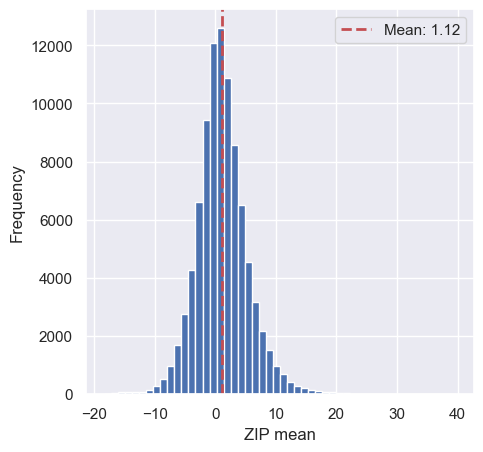

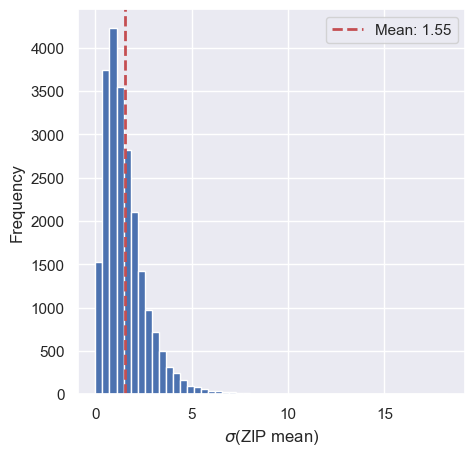

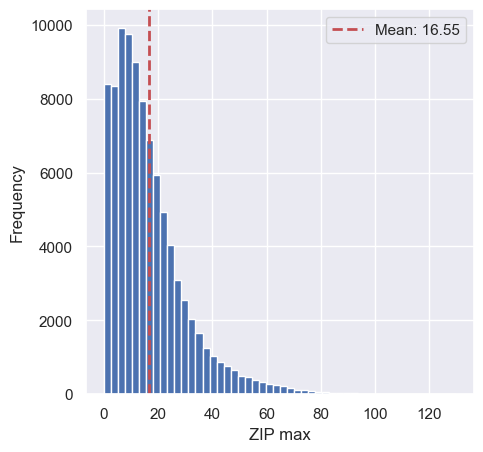

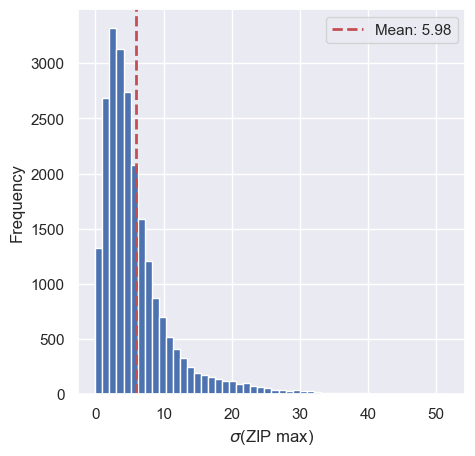

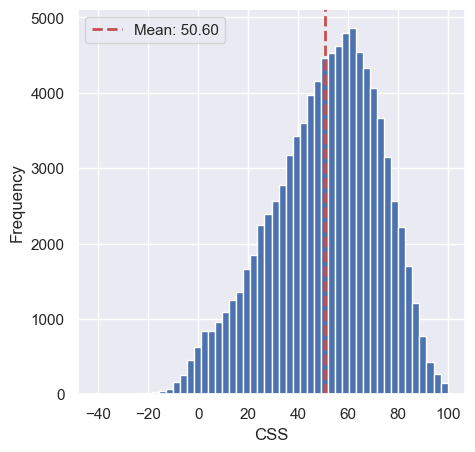

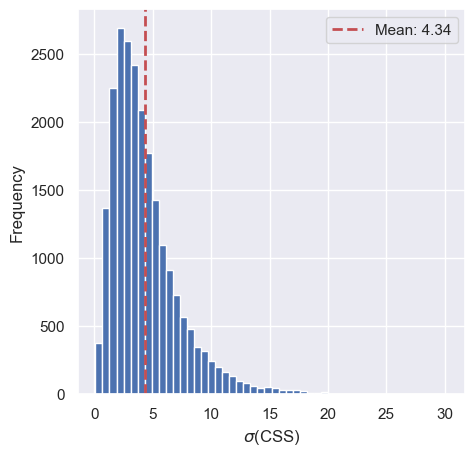

In [17]:
mean_zip_mean = df['synergy_zip_mean'].mean()
zip_mean = df['synergy_zip_mean'].hist(bins=50,figsize=(5,5))
plt.axvline(mean_zip_mean, color='r', linestyle='dashed', linewidth=2)
plt.legend([f'Mean: {mean_zip_mean:.2f}'])
plt.xlabel("ZIP mean")
plt.ylabel("Frequency")
plt.savefig(plot_path  / "synergy_zip_mean.png")
plt.show()

mean_zip_mean_std = df.groupby(["drug_1_name", "drug_2_name", "context"]).std()['synergy_zip_mean'].mean()
sub_df = df.groupby(["drug_1_name", "drug_2_name", "context"]).std()['synergy_zip_mean'].hist(bins=50,figsize=(5,5))
plt.axvline(mean_zip_mean_std, color='r', linestyle='dashed', linewidth=2)
plt.legend([f'Mean: {mean_zip_mean_std:.2f}'])
plt.xlabel(r'$\sigma$(ZIP mean)')
plt.ylabel("Frequency")
plt.savefig(plot_path  / "synergy_zip_mean_std.png")
plt.show()

mean_zip_max = df['synergy_zip_max'].mean()
zip_max = df['synergy_zip_max'].hist(bins=50,figsize=(5,5))
plt.axvline(mean_zip_max, color='r', linestyle='dashed', linewidth=2)
plt.legend([f'Mean: {mean_zip_max:.2f}'])
plt.xlabel("ZIP max")
plt.ylabel("")
plt.savefig(plot_path  / "synergy_zip_max.png")
plt.show()

mean_zip_max_std = df.groupby(["drug_1_name", "drug_2_name", "context"]).std()['synergy_zip_max'].mean()
sub_df = df.groupby(["drug_1_name", "drug_2_name", "context"]).std()['synergy_zip_max'].hist(bins=50,figsize=(5,5))
plt.axvline(mean_zip_max_std, color='r', linestyle='dashed', linewidth=2)
plt.legend([f'Mean: {mean_zip_max_std:.2f}'])
plt.xlabel(r'$\sigma$(ZIP max)')
plt.ylabel("")
plt.savefig(plot_path  / "synergy_zip_max_std.png")
plt.show()

mean_css = df['css'].mean()
css = df['css'].hist(bins=50,figsize=(5,5))
plt.axvline(mean_css, color='r', linestyle='dashed', linewidth=2)
plt.legend([f'Mean: {mean_css:.2f}'])
plt.xlabel("CSS")
plt.ylabel("")
plt.savefig(plot_path  / "css.png")
plt.show()

mean_css_std = df.groupby(["drug_1_name", "drug_2_name", "context"]).std()['css'].mean()
sub_df = df.groupby(["drug_1_name", "drug_2_name", "context"]).std()['css'].hist(bins=50,figsize=(5,5))
plt.axvline(mean_css_std, color='r', linestyle='dashed', linewidth=2)
plt.legend([f'Mean: {mean_css_std:.2f}'])
plt.xlabel(r'$\sigma$(CSS)')
plt.ylabel("")
plt.savefig(plot_path  / "css_std.png")
plt.show()

5.504539064443585


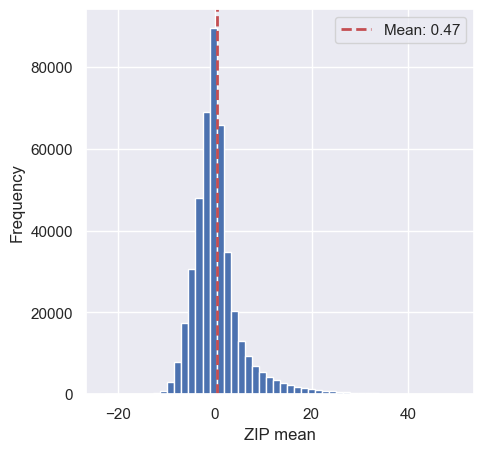

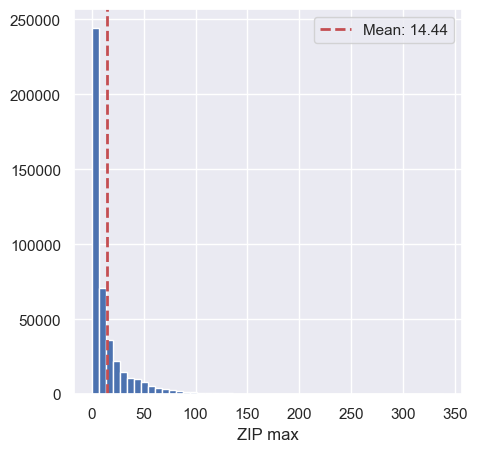

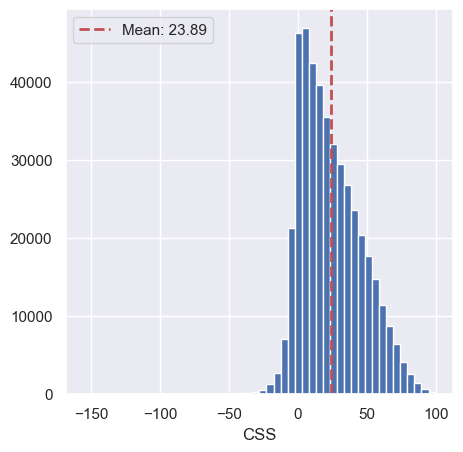

In [2]:


mean_zip_mean = df_drugcomb['synergy_zip_mean'].mean()
std = df_drugcomb['synergy_zip_mean'].std()
print(std)
zip_mean = df_drugcomb['synergy_zip_mean'].hist(bins=50,figsize=(5,5))
plt.axvline(mean_zip_mean, color='r', linestyle='dashed', linewidth=2)
plt.legend([f'Mean: {mean_zip_mean:.2f}'])
plt.xlabel("ZIP mean")
plt.ylabel("Frequency")
plt.savefig(plot_path_drugcomb  / "synergy_zip_mean.png")
plt.show()



mean_zip_max = df_drugcomb['synergy_zip_max'].mean()
zip_max = df_drugcomb['synergy_zip_max'].hist(bins=50,figsize=(5,5))
plt.axvline(mean_zip_max, color='r', linestyle='dashed', linewidth=2)
plt.legend([f'Mean: {mean_zip_max:.2f}'])
plt.xlabel("ZIP max")
plt.ylabel("")
plt.savefig(plot_path_drugcomb  / "synergy_zip_max.png")
plt.show()



mean_css = df_drugcomb['css'].mean()
css = df_drugcomb['css'].hist(bins=50,figsize=(5,5))
plt.axvline(mean_css, color='r', linestyle='dashed', linewidth=2)
plt.legend([f'Mean: {mean_css:.2f}'])
plt.xlabel("CSS")
plt.ylabel("")
plt.savefig(plot_path_drugcomb  / "css.png")
plt.show()



## Degree distribution

Number of values with correlation greater than 0.8, out of 1406 comparisons: 42.0


/usr/local/Caskroom/miniconda/base/envs/graph_pkg_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


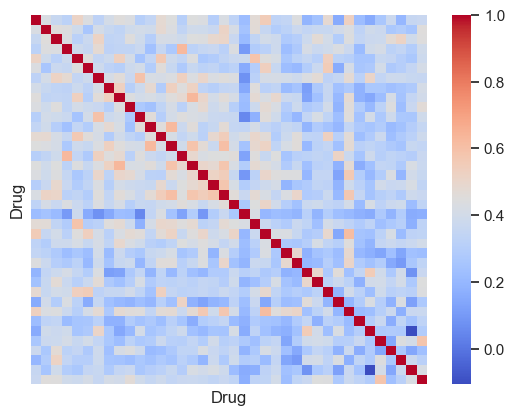

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pairs = pd.concat((df, df.rename(columns={'drug_1_name': 'drug_2_name', 'drug_2_name': 'drug_1_name'})))

df_drug = df_pairs.groupby(["drug_1_name","drug_2_name","context"]).agg({"synergy_zip_mean": "mean"}).reset_index()

zip = df_drug.pivot(
    index=["context","drug_2_name"], columns="drug_1_name", values="synergy_zip_mean").corr(numeric_only=True)

#zip_corr = zip.corr()

num_high_corr_values = (np.sum(np.abs(zip) > 0.5).sum()-38)/2
# Print the result
print(
    f"Number of values with correlation greater than 0.8, out of {38*37} comparisons: {num_high_corr_values}"
)
# Create the heatmap using seaborn
sns.heatmap(zip, cmap='coolwarm', annot=False, xticklabels=False, yticklabels=False)
plt.xlabel("Drug")
plt.ylabel("Drug")
plt.savefig(plot_path  / "drug_drug_corr.png")
plt.show()

We see that fx drug 7 has high correlation for a large variety of drugs,

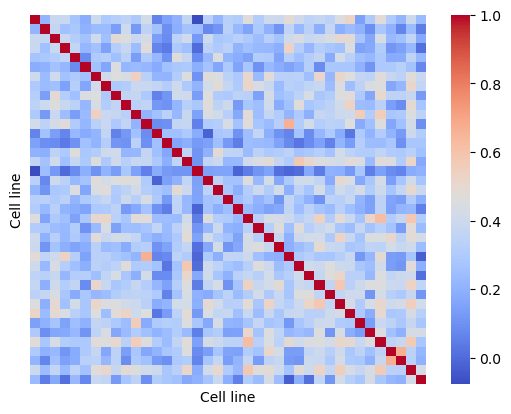

Number of values with correlation greater than 0.5, out of 1482 comparisons: 30.0
Number of values with correlation lower than -0.5, out of 1482 comparisons: 0.0


/opt/homebrew/Caskroom/miniconda/base/envs/graph_pkg_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [98]:
df_pairs_agg = df_pairs.groupby(["drug_1_name","drug_2_name","context"]).agg({"synergy_zip_mean": "mean"}).reset_index()


corr = df_pairs_agg.pivot(
    index=["drug_1_name", "drug_2_name"], columns="context", values="synergy_zip_mean"
).corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, xticklabels=False, yticklabels=False)
plt.xlabel("Cell line")
plt.ylabel("Cell line")
plt.savefig(plot_path  / "cell_line_corr.png")
plt.show()

num_high_corr_values = (np.sum(np.abs(corr) > 0.5).sum()-39)/2
# Print the result
print(
    f"Number of values with correlation greater than 0.5, out of {39*38} comparisons: {num_high_corr_values}"
)

num_high_corr_values = (np.sum(np.abs(corr) < -0.5).sum())/2
# Print the result
print(
    f"Number of values with correlation lower than -0.5, out of {39*38} comparisons: {num_high_corr_values}"
)

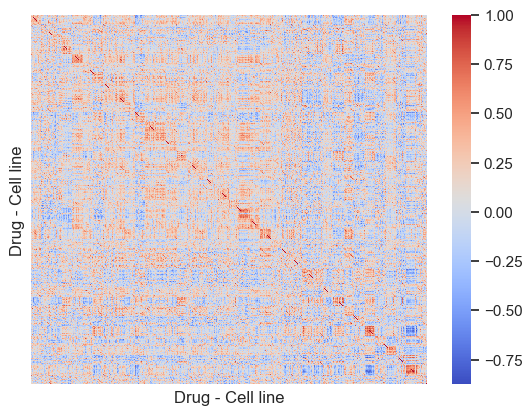

Number of values with correlation greater than 0.8, out of 169653.0 comparisons: 1186.5
Number of values with correlation lower than -0.8, out of 169653.0 comparisons: -291.5


/usr/local/Caskroom/miniconda/base/envs/graph_pkg_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [15]:
import numpy as np


df_agg_mean = df_pairs.groupby(["drug_1_name", "drug_2_name", "context"]).mean().reset_index()
corr = df_agg_mean.pivot(
    index=["drug_2_name"], columns=["drug_1_name", "context"], values="synergy_zip_mean"
).corr(numeric_only=True).fillna(0)

sns.heatmap(corr, cmap="coolwarm", annot=False, xticklabels=False, yticklabels=False)
plt.xlabel("Drug - Cell line")
plt.ylabel("Drug - Cell line")
plt.savefig(plot_path  / "drug_cell_line_drug_cell_line_corr.png", bbox_inches='tight')
plt.show()

num_high_corr_values = (np.sum(np.abs(corr) > 0.8).sum()-583)/2
# Print the result
print(
    f"Number of values with correlation greater than 0.8, out of {(583**2-583)/2} comparisons: {num_high_corr_values}"
)

num_high_corr_values = (np.sum(np.abs(corr) < -0.8).sum()-583)/2
# Print the result
print(
    f"Number of values with correlation lower than -0.8, out of {(583**2-583)/2} comparisons: {num_high_corr_values}"
)

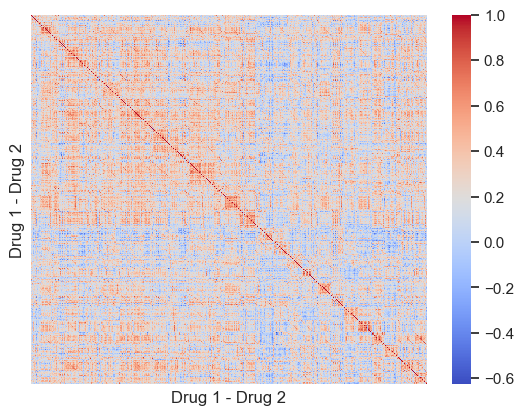

Number of values with correlation greater than 0.8, out of 169653.0 comparisons: 165.0
Number of values with correlation lower than -0.8, out of 169653.0 comparisons: -291.5


/usr/local/Caskroom/miniconda/base/envs/graph_pkg_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [14]:
import numpy as np


df_agg_mean = df.groupby(["drug_1_name", "drug_2_name", "context"]).mean().reset_index()
corr = df_agg_mean.pivot(
    index=["context"], columns=["drug_1_name", "drug_2_name"], values="synergy_zip_mean"
).corr(numeric_only=True)

sns.heatmap(corr, cmap="coolwarm", annot=False, xticklabels=False, yticklabels=False)
plt.xlabel("Drug 1 - Drug 2")
plt.ylabel("Drug 1 - Drug 2")
plt.savefig(plot_path  / "drug_pair_drug_pair_corr.png", bbox_inches='tight')
plt.show()

num_high_corr_values = (np.sum(np.abs(corr) > 0.8).sum()-583)/2
# Print the result
print(
    f"Number of values with correlation greater than 0.8, out of {(583**2-583)/2} comparisons: {num_high_corr_values}"
)

num_high_corr_values = (np.sum(np.abs(corr) < -0.8).sum()-583)/2
# Print the result
print(
    f"Number of values with correlation lower than -0.8, out of {(583**2-583)/2} comparisons: {num_high_corr_values}"
)

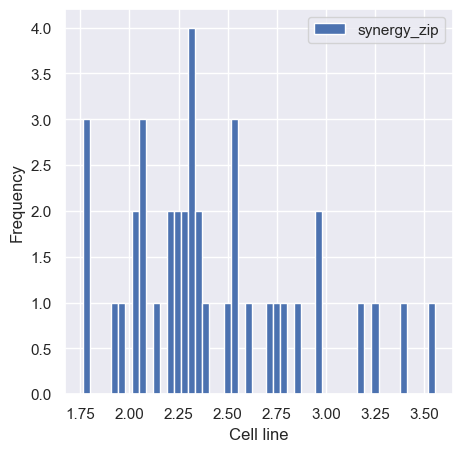

In [118]:
#violin_plot = sns.violinplot(x='context', y='synergy_zip_mean', data=df)
# df_drugcomb.groupby('context').agg({'synergy_zip_mean':'std'}).reset_index().plot(kind='hist', bins=50,figsize=(5,5))
df_intra_variance = raw.groupby(['cell_line_name','drug_row','drug_col']).agg({'synergy_zip':'std'}).reset_index()
df_intra_variance.groupby('cell_line_name').agg({'synergy_zip':'mean'}).plot(kind='hist', bins=50,figsize=(5,5),legend=None)


# Rotate the x-axis labels for better readability
#violin_plot.set_xticklabels(violin_plot.get_xticklabels(), rotation=90)
plt.xlabel(")
plt.savefig(plot_path  / "cell_line_intra_ex_variance.png")
plt.show()

In [252]:
raw.columns

Index(['block_id', 'drug_1_name', 'drug_2_name', 'context', 'study_name',
       'tissue_name', 'conc_row_unit', 'conc_col_unit', 'ic50_row', 'ic50_col',
       'ri_row', 'ri_col', 'css_row', 'css_col', 'css_ri', 'S_sum', 'S_mean',
       'S_max', 'synergy_zip', 'synergy_loewe', 'synergy_hsa', 'synergy_bliss',
       'drug_row_clinical_phase', 'drug_col_clinical_phase',
       'drug_row_target_name', 'drug_col_target_name'],
      dtype='object')

/var/folders/3x/py96fk1j3cz5hbhr3mgxcvj80000gn/T/ipykernel_26814/3857946616.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  violin_plot.set_xticklabels(violin_plot.get_xticklabels(), rotation=90)


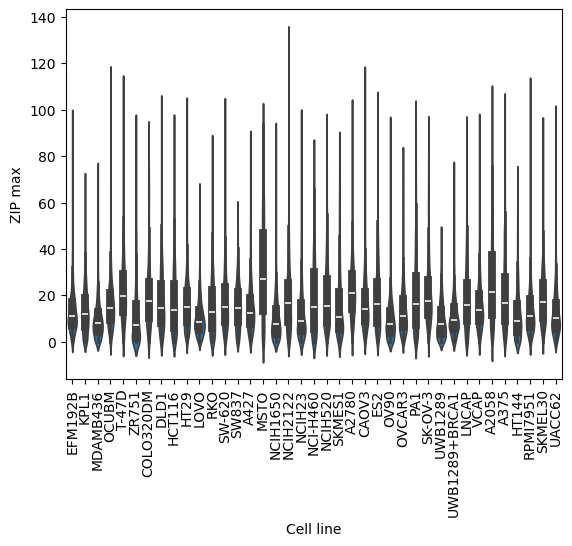

In [103]:
violin_plot = sns.violinplot(x='context', y='synergy_zip_max', data=df)
# Rotate the x-axis labels for better readability
violin_plot.set_xticklabels(violin_plot.get_xticklabels(), rotation=90)
plt.xlabel("Cell line")
plt.ylabel("ZIP max")
plt.savefig(plot_path  / "cell_line_violin_zip_max.png")
plt.show()

/var/folders/3x/py96fk1j3cz5hbhr3mgxcvj80000gn/T/ipykernel_26814/1840162659.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  violin_plot.set_xticklabels(violin_plot.get_xticklabels(), rotation=90)


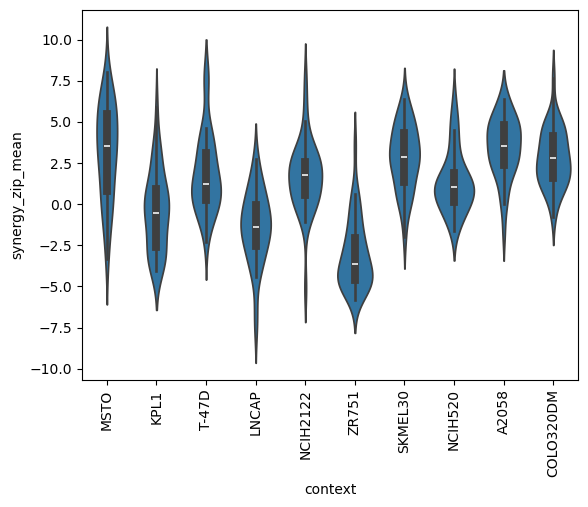

In [119]:
df_pairs_agg = df_pairs.groupby(["drug_1_name","drug_2_name","context"]).agg({"synergy_zip_mean": "mean"}).reset_index()

df_pairs_agg_variation = df_pairs_agg[(df_pairs_agg["synergy_zip_mean"] > -20) & (df_pairs_agg["synergy_zip_mean"] < 20)]
df_pairs_variation = df_pairs_agg_variation.groupby(['context','drug_1_name']).agg({'synergy_zip_mean':'mean'})
df_pairs_order = df_pairs_variation.groupby(['context']).agg({'synergy_zip_mean':'std'}).sort_values(by='synergy_zip_mean', ascending=False)
cell_line_order = df_pairs_order.index
cell_lines_to_include = cell_line_order[:10]
violin_plot = sns.violinplot(x='context', y='synergy_zip_mean', data=df_pairs_variation.loc[cell_lines_to_include])
# Rotate the x-axis labels for better readability
violin_plot.set_xticklabels(violin_plot.get_xticklabels(), rotation=90)
plt.savefig(plot_path  / "cell_line_drug_violin.png")
plt.show()

/var/folders/3x/py96fk1j3cz5hbhr3mgxcvj80000gn/T/ipykernel_26814/1653374524.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  violin_plot.set_xticklabels(violin_plot.get_xticklabels(), rotation=90)


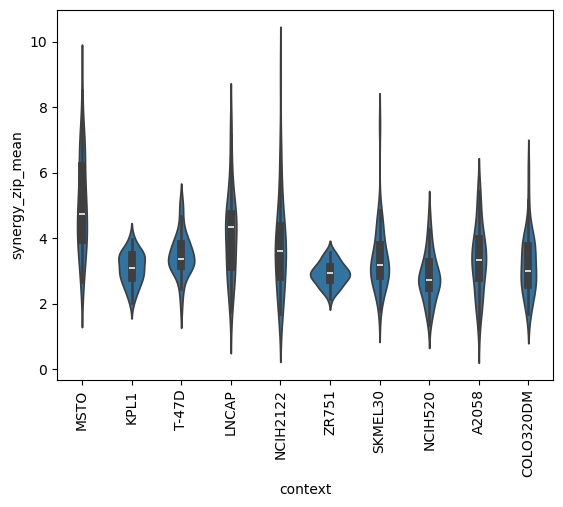

In [131]:
df_pairs_variation = df_pairs_agg_variation.groupby(['context','drug_1_name']).agg({'synergy_zip_mean':'std'})
violin_plot = sns.violinplot(x='context', y='synergy_zip_mean', data=df_pairs_variation.loc[cell_lines_to_include])
# Rotate the x-axis labels for better readability
violin_plot.set_xticklabels(violin_plot.get_xticklabels(), rotation=90)
plt.savefig(plot_path  / "cell_line_drug_std_violin.png")
plt.show()

### ONEIL-ALMANAC

In [192]:
path = Directories.DATA_PATH / "silver" / "oneil_almanac" / "oneil_almanac.csv"
plot_path = Directories.REPO_PATH / "plots" / "oneil_almanac" 
plot_path.mkdir(parents=True, exist_ok=True)

# dtype = {"drug_1_id": int, "drug_2_id": int}
oa = pd.read_csv(path)  # ,dtype=dtype)
oa.head(-10)

,block_id,drug_row,drug_col,cell_line_name,study_name,tissue_name,conc_row_unit,conc_col_unit,ic50_row,ic50_col,...,S_mean,S_max,synergy_zip,synergy_loewe,synergy_hsa,synergy_bliss,drug_row_clinical_phase,drug_col_clinical_phase,drug_row_target_name,drug_col_target_name
0,132379,Lapatinib,IMIQUIMOD,SF-268,ALMANAC,brain,uM,uM,1.385342,0.066098,...,4.3230,2.3295,0.480708,1.299466,1.100869,3.695047,4,4,Epidermal growth factor receptor erbB1; Recept...,Toll-like receptor 7
1,132384,Vorinostat,Quinacrine hydrochloride,SF-268,ALMANAC,brain,uM,uM,1.000000,1.579524,...,10.8445,10.4000,-4.752530,-0.845466,-0.705607,-2.167252,4,0,Histone deacetylase; Histone deacetylase 1; Hi...,\N
2,132627,allopurinol,thalidomide,SF-268,ALMANAC,brain,uM,uM,0.333738,0.332154,...,0.2030,-0.6795,0.484268,-0.108341,-0.905584,0.696818,4,4,Xanthine dehydrogenase; Ras-related protein Ra...,Cyclooxygenase-1; Cyclooxygenase-2; CRL4(CRBN)...
3,132670,CYTARABINE HYDROCHLORIDE,Zoledronic acid,SF-268,ALMANAC,brain,uM,uM,0.107197,0.099586,...,2.0875,-4.2640,-5.372414,-6.801107,-2.213462,-0.745943,3,4,Prelamin-A/C; Lysine-specific demethylase 4D-l...,Farnesyl diphosphate synthase; Farnesyl pyroph...
4,132819,IMIQUIMOD,Ixabepilone,SF-268,ALMANAC,brain,uM,uM,0.009530,0.014941,...,19.5025,0.7690,2.276981,-8.617173,1.267779,1.770228,4,4,Toll-like receptor 7,Tubulin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183895,431505,Vandetanib,Abiraterone,UACC62,ALMANAC,skin,uM,uM,0.372552,1.170597,...,10.0395,8.1325,-2.615100,-0.729540,1.845831,1.203377,4,4,Vascular endothelial growth factor receptor 1;...,Cytochrome P450 17A1; Cytochrome P450 21; Cyto...
183896,431558,5-Fluorouracil,paclitaxel,UACC62,ALMANAC,skin,uM,uM,100.000000,0.060000,...,19.6790,15.3270,-17.021553,-11.561982,-9.188016,-17.791852,4,4,Prelamin-A/C; Survival motor neuron protein; T...,Tubulin; Integrin alpha-V/beta-3; Prelamin-A/C...
183897,431610,mitoxantrone,Bortezomib,UACC62,ALMANAC,skin,uM,uM,0.107129,0.002522,...,17.1460,2.4600,1.073582,0.008450,0.542338,1.179213,4,4,Prelamin-A/C; Survival motor neuron protein; S...,Cathepsin G; Beta-chymotrypsin; Proteasome sub...
183898,431712,Vismodegib,Abiraterone,UACC62,ALMANAC,skin,uM,uM,11.125324,1.170597,...,3.6735,2.8955,-0.716127,2.251354,3.101860,3.866369,4,4,Sonic hedgehog protein; Smoothened homolog,Cytochrome P450 17A1; Cytochrome P450 21; Cyto...


In [134]:
block_path = Directories.DATA_PATH / "silver" / "oneil_almanac" / "block_dict.json"
df_oa = get_max_zip_response(oa,block_path)

In [191]:
oa.head()

,block_id,drug_1_name,drug_2_name,context,study_name,tissue_name,conc_row_unit,conc_col_unit,ic50_row,ic50_col,...,S_mean,S_max,synergy_zip,synergy_loewe,synergy_hsa,synergy_bliss,drug_row_clinical_phase,drug_col_clinical_phase,drug_row_target_name,drug_col_target_name
0,132379,Lapatinib,IMIQUIMOD,SF-268,ALMANAC,brain,uM,uM,1.385342,0.066098,...,4.3230,2.3295,0.480708,1.299466,1.100869,3.695047,4,4,Epidermal growth factor receptor erbB1; Recept...,Toll-like receptor 7
1,132384,Vorinostat,Quinacrine hydrochloride,SF-268,ALMANAC,brain,uM,uM,1.000000,1.579524,...,10.8445,10.4000,-4.752530,-0.845466,-0.705607,-2.167252,4,0,Histone deacetylase; Histone deacetylase 1; Hi...,\N
2,132627,allopurinol,thalidomide,SF-268,ALMANAC,brain,uM,uM,0.333738,0.332154,...,0.2030,-0.6795,0.484268,-0.108341,-0.905584,0.696818,4,4,Xanthine dehydrogenase; Ras-related protein Ra...,Cyclooxygenase-1; Cyclooxygenase-2; CRL4(CRBN)...
3,132670,CYTARABINE HYDROCHLORIDE,Zoledronic acid,SF-268,ALMANAC,brain,uM,uM,0.107197,0.099586,...,2.0875,-4.2640,-5.372414,-6.801107,-2.213462,-0.745943,3,4,Prelamin-A/C; Lysine-specific demethylase 4D-l...,Farnesyl diphosphate synthase; Farnesyl pyroph...
4,132819,IMIQUIMOD,Ixabepilone,SF-268,ALMANAC,brain,uM,uM,0.009530,0.014941,...,19.5025,0.7690,2.276981,-8.617173,1.267779,1.770228,4,4,Toll-like receptor 7,Tubulin


In [193]:
df_oa_agg_mean = oa.groupby(["drug_row", "drug_col", "cell_line_name"]).mean().reset_index()
df_oa_agg_mean.shape

TypeError: agg function failed [how->mean,dtype->object]

In [184]:
df_study_cleaned = df_oa_agg_mean.loc[
        :, ~df_oa_agg_mean.columns.str.startswith("Unnamed")
    ]

In [194]:
df_study_cleaned = oa.dropna()

In [195]:
df_study_cleaned.shape

(183910, 26)

In [198]:
def load_drugcomb():
    data_path = Directories.DATA_PATH / "bronze" / "drugcomb" / "summary_v_1_5.csv"
    return pd.read_csv(data_path)
summary = load_drugcomb()
summary_cleaned = summary.dropna(subset=["drug_row", "drug_col", "synergy_zip"])  
summary.shape

/var/folders/3x/py96fk1j3cz5hbhr3mgxcvj80000gn/T/ipykernel_26814/2591190144.py:3: DtypeWarning: Columns (2,7,19,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data_path)


(1432351, 26)

In [201]:
summary.dropna(subset=['drug_col'],inplace=True)

In [241]:
summary.tissue_name.nunique()

17

In [228]:
df_pairs_sum = pd.concat((summary, summary.rename(columns={'drug_col': 'drug_row', 'drug_row': 'drug_col'})))
df_pairs_sum_d = df_pairs_sum[["drug_row","drug_col"]].drop_duplicates()
df_pairs_sum_d.shape[0]/2

73137.5

In [230]:
unique_combinations = summary[["drug_col", "drug_row"]].nunique()
result = unique_combinations if len(unique_combinations) == 2 else unique_combinations.sum()

In [235]:
unique_combinations = summary[["drug_col", "drug_row"]].stack().unique()
result = len(unique_combinations)

In [237]:
unique_drugs = set(summary["drug_col"]).union(set(summary["drug_row"]))
unique_combinations_count = len(unique_drugs)

print("Number of unique drug combinations:", unique_combinations_count)


Number of unique drug combinations: 4268


In [242]:
unique_combinations = summary[["drug_col", "drug_row"]].apply(frozenset, axis=1).unique()
unique_combinations_count = len(unique_combinations)

print("Number of unique drug combinations:", unique_combinations_count)


Number of unique drug combinations: 73167


In [243]:
unique_triplets = summary[['drug_col', 'drug_row', 'cell_line_name']].apply(tuple, axis=1).unique()
unique_triplets_count = len(unique_triplets)

print("Number of unique triplets:", unique_triplets_count)


Number of unique triplets: 647544


In [244]:
unique_triplets

array([('717906-29-1', 'lonidamine', 'A-673'),
       ('717906-29-1', 'Ethyl bromopyruvate', 'A-673'),
       ('717906-29-1', 'Tranilast (trans-)', 'A-673'), ...,
       ('AZ13401366', 'AZD4547', 'SW780FGF'),
       ('TNF-Alpha', 'AZD5582', 'SW780FGF'),
       ('TRAIL', 'AZD5582', 'SW780FGF')], dtype=object)

In [229]:
df_pairs_sum.drug_row.nunique()

4268

In [214]:
oneil = summary[summary["study_name"] == "ONEIL"]
oneil.shape

(92208, 26)

In [215]:
df_pairs_o = pd.concat((oneil, oneil.rename(columns={'drug_col': 'drug_row', 'drug_row': 'drug_col'})))
df_pairs_new = df_pairs_o[["drug_row","drug_col"]].drop_duplicates()
df_pairs_new.shape[0]/2

583.0

In [245]:
unique_triplets = oneil[['drug_col', 'drug_row', 'cell_line_name']].apply(tuple, axis=1).unique()
unique_triplets_count = len(unique_triplets)

print("Number of unique triplets:", unique_triplets_count)


Number of unique triplets: 22737


In [208]:
almanac = summary[summary["study_name"] == "ALMANAC"]
almanac.shape

(311604, 26)

In [246]:
unique_triplets = almanac[['drug_col', 'drug_row', 'cell_line_name']].apply(tuple, axis=1).unique()
unique_triplets_count = len(unique_triplets)

print("Number of unique triplets:", unique_triplets_count)

Number of unique triplets: 309513


In [217]:
df_pairs_a = pd.concat((almanac, almanac.rename(columns={'drug_col': 'drug_row', 'drug_row': 'drug_col'})))
df_pairs_a = df_pairs_a[["drug_row","drug_col"]].drop_duplicates()
df_pairs_a.shape[0]/2

5141.0

In [219]:
df_pairs_a.drug_row.nunique()

103

In [209]:
oneil_almanac = summary[summary["study_name"].isin(['ONEIL','ALMANAC'])]
oneil_almanac.shape

(403812, 26)

In [222]:
oneil_almanac.tissue_name.nunique()

9

In [247]:
unique_triplets = oneil_almanac[['drug_col', 'drug_row', 'cell_line_name']].apply(tuple, axis=1).unique()
unique_triplets_count = len(unique_triplets)

print("Number of unique triplets:", unique_triplets_count)

Number of unique triplets: 331898


In [223]:
583*39

22737

In [218]:
df_pairs_oa = pd.concat((oneil_almanac, oneil_almanac.rename(columns={'drug_col': 'drug_row', 'drug_row': 'drug_col'})))
df_pairs_oa = df_pairs_oa[["drug_row","drug_col"]].drop_duplicates()
df_pairs_oa.shape[0]/2

5654.0

In [220]:
df_pairs_oa.drug_row.nunique()

127

In [204]:
def load_oneil():
    data_path = Directories.DATA_PATH / "silver" / "oneil" / "oneil.csv"
    return pd.read_csv(data_path)

def load_oneil_almanac():
    data_path = Directories.DATA_PATH / "silver" / "oneil_almanac" / "oneil_almanac.csv"
    return pd.read_csv(data_path)

oneil = load_oneil()
oneil_almanac = load_oneil_almanac()

In [205]:
oneil.shape

(92208, 26)